In [1]:
import json
import pandas as pd

In [2]:
# new code block
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    #df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
# new code block
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}

In [4]:
# new code block
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])


def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    #tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    #tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: 2003)
    
    
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import math,nltk,warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud,STOPWORDS


plt.rcParams["patch.force_edgecolor"] = True
#print(mlp.get_configdir())
plt.style.use('fivethirtyeight')
mlp.rc('patch',edgecolor = 'dimgray',linewidth =1)


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()
#load the dataset
credits = load_tmdb_credits(r'C:/Users/E6420/Documents/data_science_projects/tmdb_5000_credits/tmdb_5000_credits.csv')
movies = load_tmdb_movies(r'C:/Users/E6420/Documents/data_science_projects/tmdb_5000_movies/tmdb_5000_movies.csv')
#df_initial = convert_to_original_format(credits,movies)
df_initial = convert_to_original_format(movies,credits)
print('Shape',df_initial.shape)
#info on variable types and filling factor
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values'}))
tab_info = tab_info.append(pd.DataFrame((df_initial.isnull().sum()/df_initial.shape[0])*100).T.rename(index={0:'null values %'}))

tab_info

C:\Users\E6420\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Shape (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values %,0,0,64.3556,0,0,1.79055,0,0.062461,0,0,0,0.0208203,0,0.0416406,0,0,17.5724,0,0,0,0.0208203,3.62274,0.62461,1.10348,1.31168,1.93629


In [6]:
set_keywords = set()
for keyword_list in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(keyword_list,float):continue
    set_keywords = set_keywords.union(keyword_list)

In [7]:
def count_words(df,ref_col,liste):
    keyword_count = dict()
    for s in liste:
        keyword_count[s]=0
    for list_of_keywords in df[ref_col].str.split('|'):
        if type(list_of_keywords) == float and pd.isnull(list_of_keywords): continue
        for s in (s for s in list_of_keywords if s in liste):
            if pd.notnull(s): keyword_count[s]+=1
        
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1],reverse = True)
    return keyword_occurences,keyword_count

In [8]:
keyword_occurences,key_word_dict = count_words(df_initial,'plot_keywords',set_keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [9]:
keyword_occurences = [x for x in keyword_occurences if x[0]]

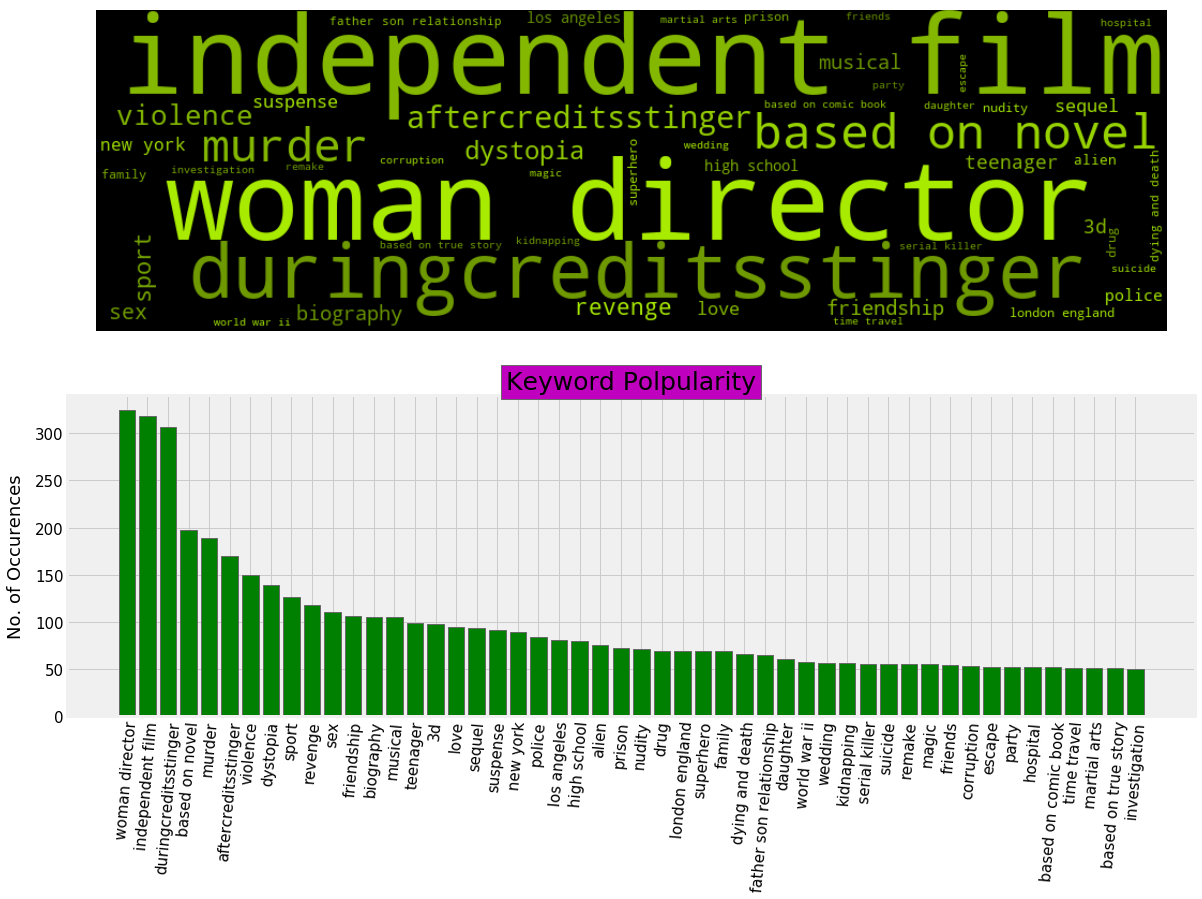

In [10]:
def random_color_func(word = None,font_size= None,position= None,orientation=None,font_path = None,random_state = None):
    h = int(360.0*tone/255.0);
    s = int(100.0*255.0/255.0);
    l = int(100.0*float(random_state.randint(70,120))/255.0)
    return "hsl({},{}%,{}%)".format(h,s,l)

fig = plt.figure(1,figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)


words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
    
tone = 55.0

wordcloud = WordCloud(width = 1000,height = 300,background_color = 'black',
                      max_words=1628,relative_scaling =1,color_func = random_color_func,normalize_plurals = False)
wordcloud.generate_from_frequencies(words);
ax1.imshow(wordcloud,interpolation='bilinear')
ax1.axis('off')


###LOWER HISTOGRAM#####
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation = 85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis,x_label)
plt.ylabel("No. of Occurences",fontsize = 18,labelpad =10)
ax2.bar(x_axis,y_axis,align= 'center',color = 'g')
plt.title("Keyword Polpularity",bbox={'facecolor':'m','pad':5},color='k',fontsize = 25)
plt.show()

In [11]:
missing_df = df_initial.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df['filling_factor']=(df_initial.shape[0]-missing_df['missing_count'])/df_initial.shape[0] *100
missing_df.sort_values('filling_factor').reset_index(drop = True)

,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


In [12]:
df_initial['decade'] = df_initial['title_year'].apply(lambda x:((x-1900)//10)*10)

def get_stats(gr):
    return {'max':gr.max() , 'min':gr.min(),'count':gr.count(),'mean':gr.mean()}


test = df_initial['title_year'].groupby(df_initial['decade']).apply(get_stats).unstack()


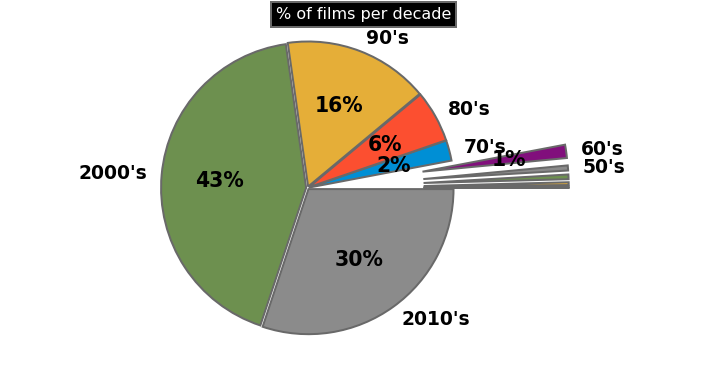

In [13]:
sns.set_context("poster", font_scale=0.85)
#_______________________________
# funtion used to set the labels
def label(s):
    
    #print(s)
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine
#____________________________________
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))



labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.8 if sizes[i] < 100 else 0.01 for i in range(11)]
ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.00f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5},color='w', fontsize=16);


#df_initial.drop('decade', axis=1, inplace = True)


In [14]:
genre_labels = set()
for s in df_initial['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [15]:
keyword_occurences, dum = count_words(df_initial,'genres',genre_labels)
keyword_occurences[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [16]:
keyword_occurences = [x for x in keyword_occurences if x[0]]
len(keyword_occurences)

20

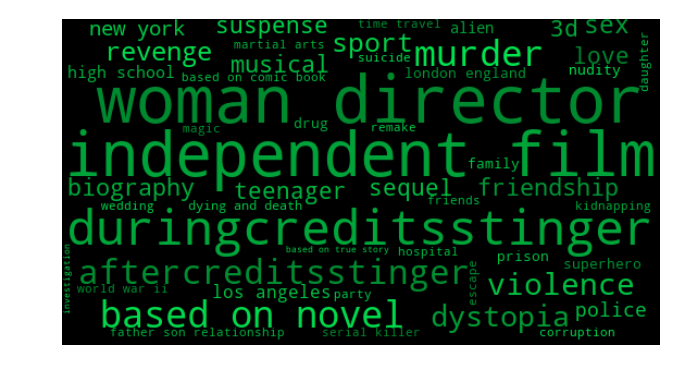

In [17]:
word = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    word[s[0]] = s[1]
tone = 100 # define the color of words

f, ax = plt.subplots(figsize=(14,6))

wordcloud = WordCloud(width=550,height=300,background_color='black',
                     max_words = 1628,relative_scaling=0.7,
                     color_func= random_color_func,
                     normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [18]:
#doubled_entries = df_initial[df_initial.duplicated()]
doubled_entries = df_initial[df_initial.id.duplicated()]
doubled_entries.shape

(0, 27)

In [19]:
#df_temp = df_initial.drop_duplicates()
df_temp = df_initial

In [20]:
list_var_duplicates = ['movie_title','title_year','director_name']

In [21]:
liste_duplicates=df_temp['movie_title'].map(df_temp['movie_title'].value_counts()>1)
print("No. of duplicate entries:{}".format(len(df_temp[liste_duplicates][list_var_duplicates])))

No. of duplicate entries:6


In [22]:
df_temp[liste_duplicates][list_var_duplicates].sort_values('movie_title')

,movie_title,title_year,director_name
1359,Batman,1989.0,Tim Burton
4267,Batman,1966.0,Leslie H. Martinson
3647,Out of the Blue,1980.0,Dennis Hopper
3693,Out of the Blue,2006.0,Robert Sarkies
972,The Host,2013.0,Andrew Niccol
2877,The Host,2006.0,Bong Joon-ho


In [23]:
#df_duplicate_cleaned = df_temp.drop_duplicates(subset=list_var_duplicates,keep='last')
df_duplicate_cleaned = df_temp

In [24]:
df_duplicate_cleaned.shape

(4803, 27)

In [25]:
def keywords_inventory(dataframe,colonne = 'plot_keywords'):
    PS = nltk.stem.PorterStemmer()
    keywords_roots = dict() #collect the words/roots
    keywords_select = dict() #association: root <> keyword
    category_keys = []
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower()
            racine = PS.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
            else:
                keywords_roots[racine] = {t}
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 2000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    print("Nb of Keywords in variable '{}' : {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select

In [26]:
keywords, keywords_roots, keywords_select = keywords_inventory(df_duplicate_cleaned,
                                                               colonne = 'plot_keywords')

Nb of Keywords in variable 'plot_keywords' : 9474


In [27]:
#Plot of a sample of keywords that appear in close varieties
#------------------------------------------------
icount = 0
for s in keywords_roots.keys():
    if len(keywords_roots[s]) > 1:
        icount +=1 
        if icount < 15 :
            print(icount,keywords_roots[s],len(keywords_roots[s]))

1 {'alien', 'alienation'} 2
2 {'spy', 'spying'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terrorism', 'terror'} 2
5 {'flood', 'flooding'} 2
6 {'spider', 'spiders'} 2
7 {'horses', 'horse'} 2
8 {'music', 'musical'} 2
9 {'animation', 'animal', 'anime'} 3
10 {'compassion', 'compass'} 2
11 {'training', 'train'} 2
12 {'sail', 'sailing'} 2
13 {'time travel', 'time traveler'} 2
14 {'orc', 'orcs'} 2


In [28]:
#Replacement of the keywords by the main form 
# this method brings uniformity in the data set
#--------------------------------
def replacement_df_keywords(df,dic_replacement,roots = False):
    df_new = df.copy(deep = True)
    for index,row in df_new.iterrows():
        var = row['plot_keywords']
        if pd.isnull(var): continue
        new_list = []
        for s in var.split('|'):
            root = PS.stem(s) if roots else s
            if root in dic_replacement.keys():
                new_list.append(dic_replacement[root])
            else:
                new_list.append(s)
        df_new.set_value(index,'plot_keywords','|'.join(new_list))
    return df_new

In [29]:
# Replacing the keyword by the main keyword
#--------------------------------------
df_keywords_cleaned= replacement_df_keywords(df_duplicate_cleaned,keywords_select,roots= True)

In [30]:
#counting the keyword occurences
#---------------------------
keyword_occurences, keywords_count = count_words(df_keywords_cleaned,'plot_keywords',keywords)
keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [31]:
# get the synonyms for the word held in the variable
#----------------------------------
def get_synonyms(var):
    
    new_set = set()
    for ss in wordnet.synsets(var):
        for w in ss.lemma_names():
            
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n':
                new_set.add(w.lower().replace('_',' '))
    return new_set

In [32]:
# list of synonyms given by nltk
var = 'alien'
new_set = get_synonyms(var)
for v in new_set:
    print(' "{:<30}" in keywords list -> {} {}'.format(v, v in keywords,
                                                keywords_count[v] if v in keywords else 0 ))

 "foreigner                     " in keywords list -> False 0
 "outlander                     " in keywords list -> False 0
 "extraterrestrial being        " in keywords list -> False 0
 "alien                         " in keywords list -> True 80
 "noncitizen                    " in keywords list -> False 0
 "extraterrestrial              " in keywords list -> True 4
 "stranger                      " in keywords list -> True 7
 "unknown                       " in keywords list -> False 0


In [33]:
def test_keyword(key,key_count,threshold):
    return (False,True)[key_count.get(key,0) >= threshold]
    

In [34]:
keyword_occurences.sort(key = lambda x:x[1],reverse = False)
key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]
#Creation of a dictionary to replace keywords by higher frequency keywords
replacement_val = dict()
icount = 0
for index,[val, nb_apparitions] in enumerate(keyword_occurences):
    if nb_apparitions > 5: continue #only the keywords that appear 5 times
    lemma = get_synonyms(val)
    if len(lemma) == 0: continue # in case of plurals
    #------------------------------------------
    list_vals = [(s, key_count[s]) for s in lemma if test_keyword(s,key_count,key_count[val])]
    
    #print("LIST_VALUES",list_vals);
    
    list_vals.sort(key = lambda x:(x[1],x[0]), reverse = True)
    
    if len(list_vals) <=1: continue #no replacement
    
    if val == list_vals[0][0]: continue #replacement by himself
    
    icount +=1
    if icount <8:
        print ('{:<12} -> {:<12} (init: {})'.format(val, list_vals[0][0],list_vals))
    replacement_val[val] = list_vals[0][0]
print(90*'_'+'\n'+'The replacement concerns {}% of the keywords'
      .format(round(len(replacement_val)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
The replacement concerns 5.98% of the keywords


In [35]:
#2 succesive replacements
#--------------------------
print('Keywords that appear in both keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in replacement_val.values():
    if s in replacement_val.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s,replacement_val[s]))           

for key, value in replacement_val.items():
    if  value in replacement_val.keys():
        replacement_val[key] = replacement_val[value]

KEYWORDS THAT APPEAR IN BOTH KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [36]:
#replacement of the keyword variety by the main word
#--------------------------------------------------
df_keywords_synonyms = replacement_df_keywords(df_keywords_cleaned,replacement_val,roots = False);
keywords,keywords_roots,keywords_select = keywords_inventory(df_keywords_synonyms,colonne='plot_keywords');

Nb of Keywords in variable 'plot_keywords' : 8908


In [37]:
#New count of keyword occurences
#-------------------------------
new_keyword_occurences,keywords_count = count_words(df_keywords_synonyms,'plot_keywords',keywords)
new_keyword_occurences[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [38]:
#deletion of keywords with low frequencies
#-----------------------------------------
def replacement_df_low_freq_keywords(df,keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences:
        key_count[s[0]] = s[1]
    for index,row in df_new.iterrows():
        var_keywords = row['plot_keywords']
        if pd.isnull(var_keywords): continue
        new_keyword_list = []
        for s in var_keywords.split('|'):
            if key_count.get(s,4)>3: new_keyword_list.append(s)
        df_new.set_value(index,'plot_keywords','|'.join(new_keyword_list))
    return df_new 

In [39]:
#creation of a dataframe where keywords of the low frequency are suppressed
#------------------------------------------------------------------------
df_keywords_occurence = replacement_df_low_freq_keywords(df_keywords_synonyms,new_keyword_occurences)
keywords,keywords_roots,keywords_select = keywords_inventory(df_keywords_occurence,colonne='plot_keywords')

Nb of Keywords in variable 'plot_keywords' : 2121


In [40]:
#new keyword count
#----------------------------------------------------------------------
new_keywords_occurences,keywords_count = count_words(df_keywords_occurence,'plot_keywords',keywords)

new_keywords_occurences[:5]

[['', 508],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

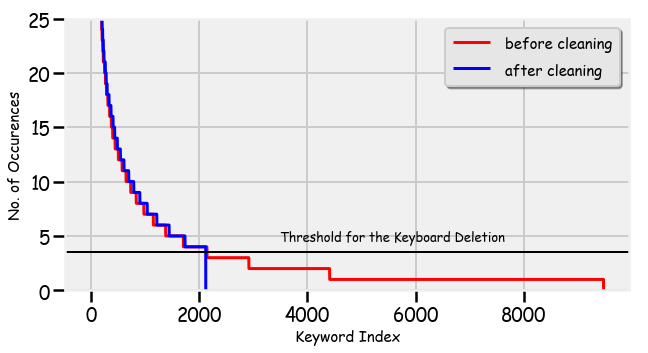

In [41]:
#Graph of the keyword occurences
#----------------------------------------------------
font = {'family':'fantasy','weight':'normal','size':15}
mlp.rc('font',**font)
keyword_occurences.sort(key = lambda x:x[1],reverse = True)
y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]


new_y_axis = [i[1] for i in new_keywords_occurences]
new_x_axis = [k for k,i in enumerate(new_keywords_occurences)]

f,ax = plt.subplots(figsize = (9,5))
ax.plot(x_axis,y_axis,'r-',label = 'before cleaning')
ax.plot(new_x_axis,new_y_axis,'b-',label= 'after cleaning')


#adding the legend by using customisations
legend = ax.legend(loc = 'upper right',shadow = True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
    
plt.ylim((0,25))
plt.axhline(y=3.5,linewidth = 2,color = 'k')
plt.xlabel('Keyword Index',family = 'fantasy',fontsize = 15)
plt.ylabel('No. of Occurences',family = 'fantasy',fontsize = 15)
plt.text(3500,4.5,'Threshold for the Keyboard Deletion',fontsize = 13)

plt.show()


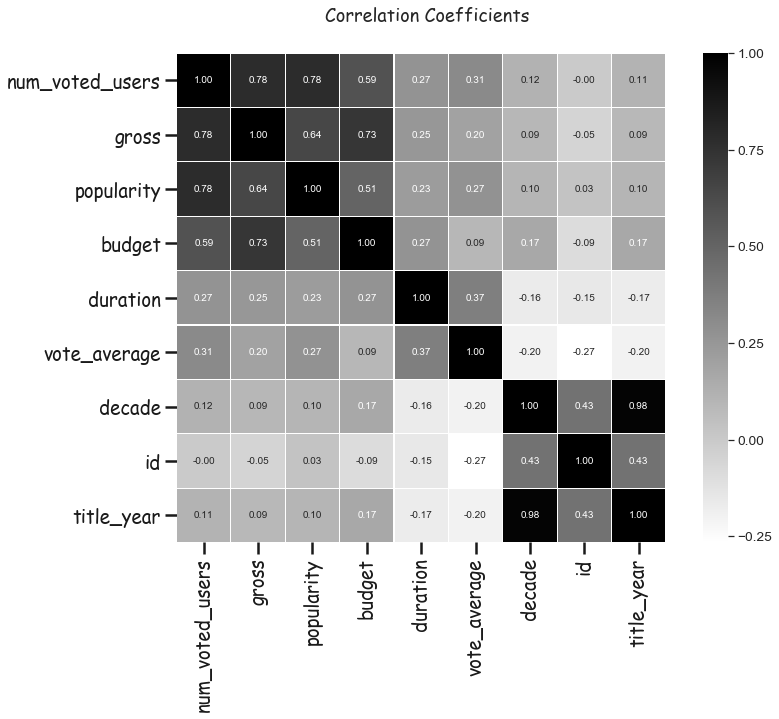

In [42]:
#Correlation 
#-------------------------------------------------
f,ax = plt.subplots(figsize = (12,9))
#calculating co-relations
corr_vals  = df_keywords_occurence.dropna(how = 'any').corr() 
#-------------------------------------------------
k = 17 #no. of variables for heat map
cols = corr_vals.nlargest(k,'num_voted_users')['num_voted_users'].index

co_rel_coeff_pearson = np.corrcoef(df_keywords_occurence[cols].dropna(how='any').values.T)
sns.set(font_scale =1.25)

heat_map = sns.heatmap(co_rel_coeff_pearson,cbar=True,annot= True,square = True,fmt = '.2f',annot_kws={'size':10},linewidth = 0.1,
                      cmap = 'binary',yticklabels = cols.values,xticklabels= cols.values)
f.text(0.5,0.93,'Correlation Coefficients',ha = 'center',fontsize = 18,family = 'fantasy')
plt.show()


In [43]:
LOST_COLUMNS= [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'    
]

In [44]:
new_column_order = ['movie_title','title_year','genres','plot_keywords','director_name','actor_1_name','actor_2_name','actor_3_name',
                    'director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','movie_facebook_likes',
                    'num_critic_for_reviews','num_user_for_reviews','num_voted_users','language','country','imdb_score','movie_imdb_link',
                    'color','duration','gross']

new_column_order = [col for col in new_column_order if col not in LOST_COLUMNS]
new_column_order = [IMDB_COLUMNS_TO_REMAP[col] if col in IMDB_COLUMNS_TO_REMAP else col for col in new_column_order]
new_column_order = [TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES[col] if col in TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES else col for col in new_column_order]
df_var_cleaned = df_keywords_occurence[new_column_order]

In [45]:
missing_df = df_var_cleaned.isnull().sum(axis = 0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df['filling_factor'] = (((df_var_cleaned.shape[0]-missing_df['missing_count'])/df_var_cleaned.shape[0])*100)
missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)

<BarContainer object of 14 artists>

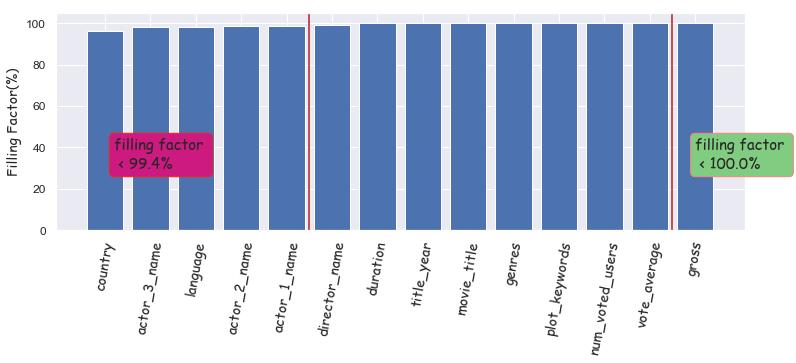

In [46]:
y_axis = missing_df['filling_factor']
x_axis = missing_df.index
x_label = missing_df['column_name']

fig = plt.figure(figsize=(11,4))
plt.xticks(rotation = 80,fontsize=14)
plt.yticks(fontsize=12)

N_thresh = 5

plt.axvline(x= N_thresh-0.5,linewidth =2,color = 'r')
plt.text(N_thresh-4.8,30,'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),fontsize =15,family = 'fantasy',
        bbox = dict(boxstyle='round',ec=(1.0,0.1,0.1),fc=(0.8,0.1,0.5)))



N_thresh = 13

plt.axvline(x= N_thresh-0.5,linewidth =2,color = 'r')
plt.text(N_thresh,30,'filling factor \n < {}%'.format(round(y_axis[N_thresh],1)),fontsize =15,family = 'fantasy',
        bbox = dict(boxstyle='round',ec=(1.0,0.5,0.5),fc=(0.5,0.8,0.5)))

plt.xticks(x_axis,x_label,family='fantasy',fontsize=14)
plt.ylabel('Filling Factor(%)',family ='fantasy',fontsize=14)

plt.bar(x_axis,y_axis)



In [47]:
df_filling = df_var_cleaned.copy(deep=True)
missing_year_info = df_filling[df_filling['title_year'].isnull()][['director_name','actor_1_name','actor_2_name','actor_3_name']]

missing_year_info[:10]

,director_name,actor_1_name,actor_2_name,actor_3_name
4553,NaN,NaN,NaN,NaN


In [48]:
def fill_year(df):
    col = ['director_name','actor_1_name','actor_2_name','actor_3_name']
    usual_year = [0 for _ in range(4)]
    var = [0 for _ in range(4)]
    # getting mean year of activity for actors and directors
    for i in range(4):
        usual_year[i] = df.groupby(col[i])['title_year'].mean()
        #print(usual_year[i].index)
        
    #Creating a dictionary for collecting this information
    
    actor_year = dict()
    for i in range(4):
        for s in usual_year[i].index:
            if s in actor_year.keys():
                if pd.notnull(usual_year[i][s]) and pd.notnull(actor_year[s]):
                    actor_year[s] = (usual_year[i][s]+actor_year[s])/2
                elif(pd.isnull(actor_year[s])):
                    actor_year[s] = usual_year[i][s]
            else:
                actor_year[s] = usual_year[i][s]
            
    #Identifying missing title year
    missing_year_info = df[df['title_year'].isnull()]
    #filling the misssing values
   
    icount_replaced = 0
    #print(missing_year_info)
    for index,row in missing_year_info.iterrows():
        value = [np.NaN for _ in range(4) ]
        icount = 0
        sum_year = 0
        for i in range(4):
            var[i] = df.loc[index][col[i]]
            #print(var[i])
            
            if pd.notnull(var[i]):
                print('in first if')
                value[i] = actor_year[var[i]]
            
            if pd.notnull(value[i]):
                print('in second if')
                icount +=1
                sum_year += actor_year[var[i]]
                
                
        if icount !=0 :
            print('in third if')
            sum_year = sum_year/icount
        
        if int(sum_year>0):
            print('in forth if')
            icount_replaced +=1
            df.set_value(index,'title_year',int(sum_year))
            if icount_replaced < 10:
                print('in fifth if')
                print('{:45} -> {:20}'.format(df.loc[index]['movie_title'],int(sum_year)))           
        return        
    

In [49]:
fill_year(df_filling)

In [50]:
###########Extract Keywords from the title##################
#get the synonym list from the words in the title
#if the synonyms are there in the keyword list, then add these keywords to the missing column plot_keywords

icount =0
for index,row in df_filling[df_filling['plot_keywords'].isnull()].iterrows():
    icount+=1
    list_var = row['movie_title'].strip().split()
    new_keyword = []
    for s in list_var:
        syn_lemma = get_synonyms(s)
        for t in list(syn_lemma):
            if t in keywords:
                new_keyword.append(t)
    if new_keyword and icount < 15:
        print('{:<50} -> {:<30}'.format(row['movie_title']),str(new_keyword))
    
    if new_keyword:
        df_filling.set_value(index,'plot_keywords','|'.join(new_keyword))
    
    

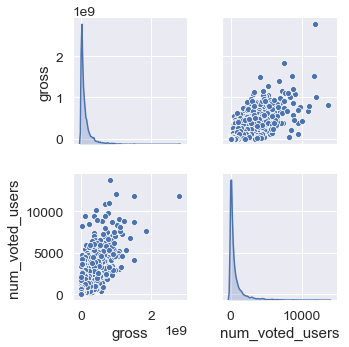

In [51]:
# we will fill the missing values of gross and num_voted_users variable
#we will make regression on the pair of co-related variables
cols = ['gross','num_voted_users']
sns.pairplot(df_filling.dropna(how='any')[cols],diag_kind='kde',size=2.5)
plt.show()

In [52]:
def variable_linear_regression(df,col_to_predict,ref_col):
    regr = linear_model.LinearRegression()
    test = df[[col_to_predict,ref_col]].dropna(how='any',axis=0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_to_predict])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X,Y)
    
    test = df[df[col_to_predict].isnull() & df[ref_col].notnull()]
    
    for index,row in test.iterrows():
        value = float(regr.predict(row[ref_col]))
        print('index',index)
        print('value',value)
        df.set_value(index,col_to_predict,value)

In [53]:
#when the function is called linear regression will be performed and using the references values of the
#second parameter of the function the missing values of the first column are filled
variable_linear_regression(df_filling,'num_voted_users','vote_average')


In [54]:
#Examining again the amount of data still missing
df = df_filling.copy(deep = True)
missing_df = df.isnull().sum(axis =0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df['filling_factor'] = (df.shape[0]-missing_df['missing_count'])/df.shape[0]*100
missing_df = missing_df.sort_values('filling_factor').reset_index(drop= True)
missing_df

,column_name,missing_count,filling_factor
0,country,174,96.377264
1,actor_3_name,93,98.063710
2,language,86,98.209452
3,actor_2_name,63,98.688320
4,actor_1_name,53,98.896523
5,director_name,30,99.375390
6,duration,2,99.958359
7,title_year,1,99.979180
8,movie_title,0,100.000000
9,genres,0,100.000000


In [55]:
#data conversion note 
# in the table above the worst filling factor is around 96
df = df_filling.copy(deep =True)
df.reset_index(inplace = True,drop = True)

################RECOMMENDATION ENGINE##########################
#1- Determine N films from the content provided by the User
#2- Select 5 most popular among these N films






In [56]:
#Defination of the Engine Function
gaussian_filter = lambda x,y,sigma :math.exp(-(x-y)**2/(2*sigma**2))

In [57]:
def entry_varibles(df,id_entry):
    col_labels = []
    if pd.notnull(df['director_name'].iloc[id_entry]):
        for s in df['director_name'].iloc[id_entry].split('|'):
            col_labels.append(s)
    
    for i in range(3):
        column = 'actor_NUM_name'.replace('NUM',str(i+1))
        if pd.notnull(df[column].iloc[id_entry]):
            for s in df[column].iloc[id_entry].split('|'):
                col_labels.append(s)
    
    if pd.notnull(df['plot_keywords'].iloc[id_entry]):
        for s in df['plot_keywords'].iloc[id_entry].split('|'):
            col_labels.append(s)
        
    return col_labels

In [58]:
def add_variables(df,REF_VAR):
    for s in REF_VAR:df[s] = pd.Series([0 for _ in range(len(df))])
    columns = ['genres','actor_1_name','actor_2_name','actor_3_name','director_name','plot_keywords']
    
            
    for column in columns:
        for index,row in df.iterrows():
            if pd.isnull(row[column]): continue
            for s in row[column].split('|'):
                if s in REF_VAR: df.set_value(index,s,1)
    return df

In [70]:
def recomend(df,id_entry):
    df_copy = df.copy(deep = True)
    list_genres = set()
    for var in df['genres'].str.split('|').values:
        list_genres = list_genres.union(set(s))
    # create additional variable to check the similarity
    variables = entry_varibles(df_copy,id_entry)
    variables += list(list_genres)
    df_new = add_variables(df_copy,variables)
    #determination of the closest nieghbors
    
    X =df_new.as_matrix(variables)
    nbrs = NearestNeighbors(n_neighbors = 31,algorithm = 'auto',metric = 'euclidean').fit(X)
    
    distances,indices = nbrs.kneighbors(X)
    xtest = df_new.iloc[id_entry].as_matrix(variables)
    xtest = xtest.reshape(1,-1)
    
    distances, indices = nbrs.kneighbors(xtest)
       
    return indices[0][:]

In [76]:
def extract_parameters(df,list_films):
    parameters_films = ['_' for _ in range(31)]
    i = 0
    max_users = -1
    for index in list_films:
        parameters_films[i] = list(df.iloc[index][['movie_title','title_year','imdb_score','num_user_for_reviews','num_voted_users']])
        
        parameters_films[i].append(index)
        max_users = max(max_users,parameters_films[i][4])
        i+=1
        
    title_main = parameters_films[0][0]
    ann_ref = parameters_films[0][1]
    
    parameters_films.sort(key = lambda x : criteria_selection(title_main,max_users,ann_ref,x[0],x[1],x[2],x[4]),reverse = True)
    
    return parameters_films    

In [78]:
def sequel(title_1,title_2):
    if fuzz.ratio(title_1,title_2) > 50 or fuzz.token_set_ratio(title_1,title_2) > 50:
        return True
    else:
        return False

In [64]:
def criteria_selection(title_main,max_users,annee_ref,title,annee,imdb_score,votes):
    if pd.notnull(annee_ref):
        factor_1 = gaussian_filter(annee_ref,annee,20)
    else:
        factor_1 = 1
    
    sigma = max_users*1
    
    
    if pd.notnull(votes):
        factor_2 = gaussian_filter(votes,max_users,sigma)
    else:
        factor_2 = 0
    
    
    if sequel(title_main,title):
        note = 0
    else:
        note = imdb_score**2 * factor_1 * factor_2
    
    return note

In [65]:
def add_to_selection(film_selection,film_parameter):
    film_list = film_selection[:]
    icount = len(film_list)
    
    for i in range(31):
        already_in_list = False
        
        for s in film_selection:
            if s[0] == film_parameter[i][0]: already_in_list = True
            if sequel(film_parameter[i][0],s[0]): already_in_list = True
        
        if already_in_list : continue
        icount +=1
        
        if icount <= 5:
            film_list.append(film_parameter[i])
            
    return film_list

In [66]:
def remove_sequels(film_selection):
    removed_from_selection = []
    for i, film_1 in enumerate(film_selection):
        for j,film_2 in enumerate(film_selection):
            if j <=i :continue
            if sequel(film_1[0],film_2[0]):
                last_film = film_2[0] if film_1[1] < film_2[1] else film_1[0]
                removed_from_selection.append(last_film)
    
    film_list = [film for film in film_selection if film[0] not in removed_from_selection]
    
    return film_list

In [81]:
def find_similarities(df,id_entry,del_sequels = True, verbose = False):
    if verbose:
        print(90*'_'+'\n'+"Query: films similar to id={} -> '{}'".format(id_entry,
                                                                         df.iloc[id_entry]['movie_title']))
        
    
    list_films = recomend(df,id_entry)
    
    parameter_films = extract_parameters(df,list_films)
    
    film_selection = []
    
    film_selection = add_to_selection(film_selection,parameter_films)
    
    if del_sequels: 
        film_selection = remove_sequels(film_selection)
    
    film_selection = add_to_selection(film_selection,parameter_films)
    
    selection_titles = []
    
    for i,s in enumerate(film_selection):
        selection_titles.append([s[0].replace(u'\xa0',u''),s[5]])
        if verbose:
            print("no{:<2}   ->{:<30}".format(i+1,s[0]))
            
            
    return selection_titles

In [83]:
dum = find_similarities(df, 2, del_sequels = False, verbose = True)

__________________________________________________________________________________________
Query: films similar to id=2 -> 'Spectre'
no1    ->Spectre                       
no2    ->Skyfall                       
no3    ->The Bourne Supremacy          
no4    ->Spy Kids: All the Time in the World
no5    ->Clear and Present Danger      
